# imports:

In [1]:
from os import listdir,mkdir,makedirs
from os.path import isfile, join, isdir,exists
import pandas as pd
import numpy as np
from scipy import stats
import re
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from myplots import roundup, rounddown, find_decimal_fold, percentile_cut_off, rarefaction_calc, rarefaction_plot,draw_correlation_scatter
from matplotlib.ticker import FormatStrFormatter
import cPickle as pickle
from Bio.SeqUtils import GC
import seaborn as sns
import random
from scipy.stats import pearsonr,fisher_exact
from skbio.diversity.alpha import shannon, simpson, berger_parker_d

from pop_organize import get_sample_data, get_sample_with_dfs
from SufficientStatistics import *
from MyFunctionsShani import *
import math
from myplots import roundup, rounddown, find_decimal_fold
from skbio.stats.distance import mantel
from scipy.spatial.distance import braycurtis, pdist, euclidean


from GeneralFeaturePhenotypeInteractions.Feature_phenotype_functions import * 
from TCR_microbiome_interactions.TCR_microbiome_interactions_functions import *
from TCR_microbiome_interactions.TCR_microbiome_interactions_functions2 import *
from SampleLists.SampleFileFunctions import *
from PhenotypicData.PhenotypeGenerationFunctions import *
from CardioProject.CardioFunctions import *
from PredictionPipeline.PredictionFunctions import *
from TCR_feature_generation.SubsamplingFunctions import *

import os
from Utils import cacheOnDisk
from SegalQueue.qp import qp,fakeqp
from addloglevels import sethandlers

#ML imports:
from xgboost import XGBClassifier
import lightgbm as lgb
from collections import OrderedDict
from sklearn.model_selection import GroupKFold,StratifiedKFold, KFold
import statsmodels.formula.api as sm
from sklearn.linear_model import LogisticRegression
import shap
from sklearn import metrics, preprocessing
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel,SelectKBest,chi2,mutual_info_classif,f_classif
from sklearn.naive_bayes import GaussianNB

MyPath='/net/mraid08/export/genie/Lab/Personal/ShaniBAF'

done1
stop
stop
done1
stop
done
done
done
done
stop
stop
end of function!!!


/usr/wisdom/python/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


end of function!!!


In [2]:
import time
cdate=str(time.strftime("%d%m%Y"))
cdate

'07102018'

# Figure 1:

## B. feature distribution

1. load feature files
2. choose 9 features to compare
3. generate plot with subplots
4. plot each subplot with the distribution plotting funcion (add p-values etc.) - try to plot KDE!

### generate new feature file:

the function complete_TCRfeatureExtractionForDataset was copied to TCR_feature_generation.py

In [ ]:
# GENERATE FEATURE DF FOR PNP530:
datasetFolder='%s/TCR_real_data' %MyPath
print datasetFolder
datasetName='PNP530'

complete_TCRfeatureExtractionForDataset(datasetFolder,datasetName)

In [ ]:
# GENERATE FEATURE DF FOR Cardio126:
datasetFolder='%s/TCR_real_data/CardioSamples' %MyPath
print datasetFolder
datasetName='Cardio126'

complete_TCRfeatureExtractionForDataset(datasetFolder,datasetName)

In [ ]:
f1='%s/TCR_real_data/featureSummaryDFs/PNP530_allFeatures' %MyPath
PNP530_allFeatures=pd.read_pickle(f1)

print PNP530_allFeatures.shape

f2='%s/TCR_real_data/CardioSamples/featureSummaryDFs/Cardio126_allFeatures' %MyPath
Cardio126_allFeatures=pd.read_pickle(f2)

print Cardio126_allFeatures.shape

### remove correlated, constant and fillnas:

In [ ]:
# remove correlated:
filterFeaturesByCorr=1

ss=None
repeat=None
genFeatureDF=True
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530','rb') as fp:
    PNP530=pickle.load(fp)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126','rb') as fp:
    Cardio126=pickle.load(fp)
sampleList=PNP530+Cardio126
sampleListName='PNP530Cardio126'
print len(sampleList)


TCRfeatureDF3=removeRedundantFeatures(ss,repeat,filterFeaturesByCorr,sampleList,sampleListName,genFeatureDF)
 

In [ ]:
# explore file:
f1='%s/TCR_real_data/PNP530Cardio126Combined/featureSummaryDFs/PNP530Cardio126_filteredByPNP530Cardio126_allFeatures_noCorrelated' %MyPath
featureDF=pd.read_pickle(f1)
df=explore_feature_table(featureDF)

f3='%s/TCR_real_data/PNP530Cardio126Combined/featureSummaryDFs/PNP530Cardio126_filteredByPNP530Cardio126_allFeatures_\
noCorrelated_ANALYSIS.xlsx' %MyPath
df.to_excel(f3)

In [ ]:
# remove constant:
# remove constant columns - there are no such columns now
constantdf=df[df['Type']=='constant']
constantVars=constantdf['columns'].tolist()
print constantVars
print featureDF.shape
featureDF=featureDF.drop(constantVars,axis=1)
print featureDF.shape

In [ ]:
#fillna all gene usage features:
colsTofill=[x for x in featureDF.columns.values if 'norm' not in x]
print len(colsTofill)
print len(featureDF.columns)

featureDF[colsTofill]=featureDF[colsTofill].fillna(0)

In [ ]:
f3='%s/TCR_real_data/PNP530Cardio126Combined/featureSummaryDFs/PNP530Cardio126_filteredByPNP530Cardio126_allFeatures_\
noCorrelated_noConsts_filledna.xlsx' %MyPath

featureDF.to_excel(f3)

f4='%s/TCR_real_data/PNP530Cardio126Combined/featureSummaryDFs/PNP530Cardio126_filteredByPNP530Cardio126_allFeatures_\
noCorrelated_noConsts_filledna' %MyPath

featureDF.to_pickle(f4)

### generate feature comparison figure:

In [ ]:
# LOAD FEATURE FILE AND DIVIDE INTO PNP AND CARDIO:

f1='%s/TCR_real_data/PNP530Cardio126Combined/featureSummaryDFs/PNP530Cardio126_filteredByPNP530Cardio126_\
allFeatures_noCorrelated_noConsts_filledna' %MyPath
featureDF=pd.read_pickle(f1)

# LOAD SAMPLE LISTS:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530','rb') as fp:
    PNP530=pickle.load(fp)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126','rb') as fp:
    Cardio126=pickle.load(fp)
    
#GENERATE pnp feature file:
PNPfeatureDF=featureDF.loc[PNP530,:]
print 'PNP feature df shape is %s_%s' %(PNPfeatureDF.shape[0],PNPfeatureDF.shape[1])
print PNPfeatureDF.iloc[:4,:4]
print PNPfeatureDF['V18-01_T'].head()

#GENERATE cardio feature file:
CardiofeatureDF=featureDF.loc[Cardio126,:]
print 'Cardio feature df shape is %s_%s' %(CardiofeatureDF.shape[0],CardiofeatureDF.shape[1])
print CardiofeatureDF.iloc[:4,:4]
print CardiofeatureDF['V18-01_T'].head()
    


In [ ]:
# choose most interesting features to present:

#clonality and diversity:  meanClonal_nt_T, topClonal_nt_T, shannon_nt_T, normSeqNums_per2000_NT_T
# length: n1Insertion_mean_T,n2Insertion_mean_T, cdr3Length_mean_T
#gene usage: V05_J02_T,V18_T,V25_T

interestingFeatures=['frequencyCount (%)_mean_T','top10clonal_nt_T','shannon_nt_T','n1Insertion_mean_T','n2Insertion_mean_T',
                    'cdr3Length_mean_T','V05_J02_T','V18_J02_T','V25_T']

fig1,axes=plt.subplots(nrows=3, ncols=3,figsize=(16,12),sharey=True)

for n,feature in enumerate(interestingFeatures):
    print n,feature
    ax=axes.flatten()[n]
    dataList=[('Healthy',PNPfeatureDF[feature]),('Patients',CardiofeatureDF[feature])]
    title=feature
    ax,ks_p_cohort1_cohort2,t_p_cohort1_cohort2,p_Anov,filename=plotHistComprison(dataList,ax,title)
    if n!=0:
        ax.legend('')
    else:
        ax.legend(bbox_to_anchor=(0.5,1.5),fontsize=22)
              
fig1.suptitle('TCR Feature Comparison: Healthy vs. Controls', fontsize=22)
fig1.subplots_adjust(left=0.01,right=0.99,bottom=0.02, hspace=0.3,top=0.85)
figName='1B-TCR feature comparison Healthy vs controls'
folder='%s/Presentations and Manuscripts/ImmunoRepertoire conference - Paris2018/Poster' %MyPath
figFile='%s/%s' %(folder,figName)
fig1.savefig(figFile,dpi=300)
plt.show()

In [ ]:
f1='%s/TCR_real_data/CardioSamples/descriptiveStatsSamplesForAnalysis/Total/ClonalityFeatures/BD1061' %MyPath
df=pd.read_pickle(f1)
df.head()

## C. phenotype-TCR feature correlations

1. generate a matrix of phenotype by feature figures - correlation or histogram comparisons, depnding on datatype
2. calculate nTest and pCut off according to bonferroni correction
3. mark all subplots with sig p value after correction
4. decide which columns/rows to delete and repeat all
5. make nicer plot and save.
6. copy functions to .py and delete from notebook

### collect relvenat phenotypes and features:

In [ ]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530','rb') as fp:
        PNP530=pickle.load(fp)

#get relevant phenotypes:
f1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/NewPhenotypicData/newPhenotypesPNPAllInfo_withDummies.xlsx'
PNP530_phen_new_dummies=pd.read_excel(f1).set_index('BD')
PNP530_phen_new_dummies=PNP530_phen_new_dummies.loc[PNP530,:]
corr_phens=PNP530_phen_new_dummies[['Age','BMI','Total Cholesterol','HbA1C','Glucose','Gender','Smoking Status']]
print corr_phens.head()

#get relevant features:
featureDFfile='%s/TCR_real_data/PNP530Cardio126Combined/featureSummaryDFs/PNP530Cardio126_filteredByPNP530Cardio126\
_allFeatures_noCorrelated_noConsts_filledna' %MyPath
TCRfeatureDF2=pd.read_pickle(featureDFfile)

PNP530featureDF=TCRfeatureDF2.loc[PNP530,:]
corr_feats=PNP530featureDF[['normSeqNums_per2000_NT_T','top10clonal_nt_T','frequencyCount (%)_mean_T',
                            'shannon_nt_T','cdr3Length_mean_T','n1Insertion_mean_T']]
print corr_feats.head()

#merge:
corr_phens_feats=pd.merge(corr_phens,corr_feats,how='inner',left_index=True,right_index=True)
print corr_phens_feats.head()
print len(corr_phens_feats)
print len(corr_phens)
print len(corr_feats)

### generate correlation plot

the function plot_corr was copied to MyFunctionsShani.py

In [ ]:
data1=PNP530_phen_new_dummies['Age'].tolist()
data1name='Age'
data2=PNP530featureDF['normSeqNums_per2000_NT_T'].tolist()
data2name='normSeqNums_per2000_NT_T'
stdToReject=None
title=data1name+' vs. '+data2name

fig,ax=plt.subplots()

plot_corr(data1,data2,data1name,data2name,ax,stdToReject,title)

plt.show()

the function  plotHistComprison was copied to MyFunctionsShani

In [ ]:
featCols=corr_feats.columns  #define figure columns. additional column of TCRdf distMat will be added
phenCols=corr_phens.columns #define figure rows

#define figure design according to the number of features and phenotype used:
fig1, axes=plt.subplots(nrows=len(phenCols),ncols=(len(featCols)+1),figsize=(4*(len(featCols)+1),3*len(phenCols)))

#load TCRdf distMats:
f2='%s/TCR_real_data/distanceMatrices/TCRdfminNshared2RAonlyProductiveTruepercShared10OLtrimmed_binary_jaccard_distMat_CONDENSED'  %MyPath
binaryTCRdfdistMat_CONDENSED=pd.read_pickle(f2)

fig1.text(-0.012+6*0.147,0.92-(0.13*5)/2,'TCR public seq repertoire Jaccard distance',fontsize=20,fontweight='bold',verticalalignment='center',rotation=90 )
for i,phenotype in enumerate(phenCols):
    fig1.text (0.5,0.93-(i*0.136),phenotype,fontsize=20,fontweight='bold',horizontalalignment='center')
    
    for j,feature in enumerate(featCols):
        fig1.text(-0.012+j*0.147,0.92-(0.13*5)/2,feature,fontsize=20,fontweight='bold',verticalalignment='center',rotation=90 )
        fig1.text(-0.012+j*0.147,0.92-(0.13*6),'%s freq' %feature,fontsize=20,fontweight='bold',verticalalignment='center',rotation=90 )
        print phenotype
        ax=axes[i,j]
        if i<5: # generate all subplots with simple correlation:
            data1=corr_phens_feats[phenotype].tolist()
            data1name=phenotype
            data2=corr_phens_feats[feature].tolist()
            data2name=feature

            ax, nsamples,r,p=plot_corr(data1,data2,data1name,data2name,ax)
            ax.set_xlabel('')
            ax.set_ylabel('')
        else: # generate all subplots that compare histograms between phenotype categories
            data=corr_phens_feats[[phenotype,feature]] #generate df that contains one feature and one phenotype
            groups=data.groupby(phenotype) #group the df by the phenotype cateogries
            dataList=[] #generate datalist constitutes of tuples, each tuple contain a category name and its relevent feature data
            print '-groups- length is %s' %len(groups)
            for name,group in groups:
                tupList=[]
                tupList.append(name)
                groupData=[x for x in group[feature].tolist() if not np.isnan(x)]
                tupList.append(groupData)
                tup=tuple(tupList)
                dataList.append(tup)

            title=None
            ax,ks_p_cohort1_cohort2,t_p_cohort1_cohort2,p_Anov,filename=plotHistComprison(dataList,ax,title,
                                                        showLegend=True,nBins=10,toAnnotate=False,alpha=0.5,
                                                            plotType='kde')  #plot kde histogram for each phen category
#             ax.set_ylabel('%s - frequency' %feature,fontsize='medium')
            #delete existing text and add another one instead:
            if not np.isnan(p_Anov):
                ax.annotate('p_Anov=%s' %round(p_Anov,4),xy=(0.02, 0.96), xycoords='axes fraction', 
    fontsize='x-large', horizontalalignment='left', verticalalignment='top', fontweight='bold',color='red')
            else:
                ax.annotate('ttest_p=%s' %round(t_p_cohort1_cohort2,4),xy=(0.02, 0.96), xycoords='axes fraction', 
            fontsize='x-large', horizontalalignment='left', verticalalignment='top', fontweight='bold',color='red')

            if j!=0: #add legend only for the left-most subplot
                ax.legend('')
            else:
                ax.legend(bbox_to_anchor=(0.05, 0.95), fontsize='large',loc='upper left')
#         if j==3: # add row title:
#                 ax.set_title(phenotype, fontsize=24, fontweight='bold')

        
        ax=axes[i,len(featCols)]
        ax.set_xlabel('')
        ax.set_ylabel('')
    if i<5: #generate the subplots that contains correlation plot for diistmats:
        
        #load phenDistMat:
        f1='%s/TCR_real_data/phenDistMats/PNP530_%s_euclidean_distMat_CONDENSED' %(MyPath,phenotype)
        phenDistMat_CONDENSED=pd.read_pickle(f1)
        phenDistMat_CONDENSED=phenDistMat_CONDENSED.set_index(['sample1','sample2']).loc[binaryTCRdfdistMat_CONDENSED\
.set_index(['sample1','sample2']).index,:].reset_index() #make sure the data in the phenDistMat is matched
                                                                 # to the one in the TCRdf distMat

        data2=binaryTCRdfdistMat_CONDENSED['dist'].tolist()
        data1=phenDistMat_CONDENSED['dist'].tolist()
        data2name='TCR public seq repertoire distance'
        data1name='%s distance' %phenotype
        ax, nsamples,r,p=plot_corr(data1,data2,data1name,data2name,ax)
        ax.set_xlabel('Euclidean distance between samples')
        ax.set_ylabel('')
    else:
        fig1.delaxes(ax)




                
                      
            
fig1.suptitle("Phenotype-TCR feature interaction in the healthy cohort", fontsize=26, fontweight='bold')
fig1.subplots_adjust(left=0.02,right=0.99,bottom=0.02, wspace=0.5, hspace=0.6,top=0.92)
figName='1C-PNP530-Phenotype-TCR feature interaction'
folder='%s/Presentations and Manuscripts/ImmunoRepertoire conference - Paris2018/Poster' %MyPath
figFile='%s/%s' %(folder,figName)
fig1.savefig(figFile,dpi=300,bbox_inches='tight')
plt.show()
        

### calculate p-cut with bonferroni correction:

In [ ]:
nTests=47
pCut=0.05/47
print pCut

# figure 2:

## A - feature comparison  - p value jitter plot

### generate summarizing file:
a file containing features,ttest_pvalues,ttest_FDR,ttest_bonferroni for each dataset

0 (5000, 3)
(714, 7)
1 (9000, 3)
(1434, 7)
2 (12500, 3)
(2150, 7)
(34, 7)
['ss5000rep3' 'ss9000rep3' 'ss12500rep3']
['ss5000rep3' 'ss9000rep3' 'ss12500rep3']
['ss5000rep3' 'ss9000rep3' 'ss12500rep3']


/usr/wisdom/python/lib/python2.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


(2150, 7)


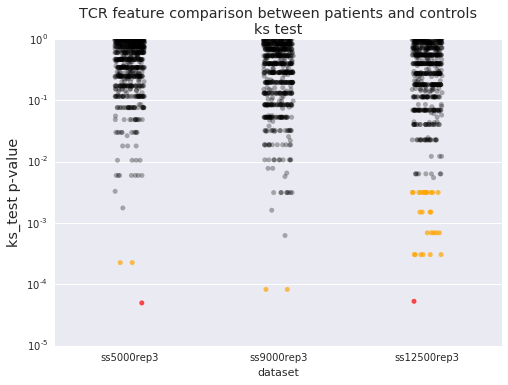

In [18]:
datasetList=[(5000,3),(9000,3),(12500,3)]
stat='ks' #'t'/'ks'

for n,dataset in enumerate(datasetList):
    print n, dataset
    ss=dataset[0]
    repeat=dataset[1]
    
    datasetFolder='%s/TCR_real_data/PNP530Cardio126Combined/MatchedSamples/ss%srep%s' %(MyPath,ss,repeat)
    featureCompFile='%s/featureSummaryDFs/FeatureMeanSummary_Cardio126_ss%s_rep%s\
CardioMatchedss%srep%s_PNP530_ss%s_rep%sPNPMatchedss%srep%s' %(datasetFolder,ss,repeat,ss,repeat,ss,repeat,ss,repeat)
    featureCompDF=pd.read_pickle(featureCompFile)
    short=featureCompDF[['%s_p' %stat,'Sig by bonferroni corrected pVal_%s' %stat,'sig. by FDR=0.1_%s' %stat]]
    short=short.reset_index().rename(columns={'index':'feature'})
    
    toadd=pd.DataFrame({'feature':['',''],'%s_p' %stat: [np.nan,np.nan],'Sig by bonferroni corrected pVal_%s' %stat : [0,1],'sig. by FDR=0.1_%s' %stat : [1,1]})
    short=pd.concat([short,toadd], ignore_index=True)
    
    short['dataset']='ss%srep%s' %(dataset[0],dataset[1])
    short['dataset_xloc']=n+1/len(datasetList)
    short['color1']=short['sig. by FDR=0.1_%s' %stat]+short['Sig by bonferroni corrected pVal_%s' %stat]   
    
    if n==0:
        sumDF=short
    else:
        sumDF=pd.concat([sumDF,short], ignore_index=True)
        
    print sumDF.shape



noSig=sumDF[(sumDF['sig. by FDR=0.1_%s' %stat]!=1)&(sumDF['Sig by bonferroni corrected pVal_%s' %stat]!=1)]
FDRsig=sumDF[(sumDF['sig. by FDR=0.1_%s' %stat]==1)&(sumDF['Sig by bonferroni corrected pVal_%s' %stat]!=1)]
bonfSig=sumDF[sumDF['Sig by bonferroni corrected pVal_%s' %stat]==1]
print FDRsig.shape

print noSig['dataset'].unique()
print FDRsig['dataset'].unique()
print bonfSig['dataset'].unique()

    
f1='%s/TCR_real_data/PNP530Cardio126Combined/MatchedSamples/featureComparisonSummary_concat_%s.xlsx' %(MyPath,stat)
sumDF.to_excel(f1)
    
print sumDF.shape

fig,ax=plt.subplots()
# sns.stripplot(x='dataset',y='%s_p' %stat, data=sumDF, jitter=True, edgecolor='none', alpha=.30,
#               hue='color1')

try:
    sns.stripplot(x='dataset',y='%s_p' %stat, data=bonfSig, jitter=True, edgecolor='none', alpha=.70,
              color='red')
except:
    print "couldn't plot Bonfsig"
    
try:
    sns.stripplot(x='dataset',y='%s_p' %stat, data=FDRsig, jitter=True, edgecolor='none', alpha=.70,
              color='orange')
except:
    print "couldn't plot FDRsig"


sns.stripplot(x='dataset',y='%s_p' %stat, data=noSig, jitter=True, edgecolor='none', alpha=.30,
              color='black')


    
# for point in bonfSig.index:
#     print bonfSig.loc[point,'feature']
#     ax.annotate(bonfSig.loc[point,'feature'],xy=(bonfSig.loc[point,'dataset_xloc']+0.00001,
#                 bonfSig.loc[point,'%s_p' %stat]+0.00001),xycoords='data',
#                fontsize='xx-small',horizontalalignment='left', verticalalignment='top',color='red')
sns.despine()
ax.legend(loc='best')
ax.set_ylim(0.00001,1)
ax.set_yscale('log')
ax.set_title('TCR feature comparison between patients and controls\n%s test' %stat, fontsize='large')
ax.set_ylabel('%s_test p-value' %stat, fontsize='large')
plt.show()  

figName='2B_featureComparisonJitter_%s' %stat
folder='%s/Presentations and Manuscripts/ImmunoRepertoire conference - Paris2018/Poster' %MyPath
figFile='%s/%s' %(folder,figName)
fig.savefig(figFile,dpi=300,bbox_inches='tight')
    
    

# figure 3

## A. phenotype-TCR feature correlations

1. generate a matrix of phenotype by feature figures - correlation or histogram comparisons, depnding on datatype
2. calculate nTest and pCut off according to bonferroni correction
3. mark all subplots with sig p value after correction
4. decide which columns/rows to delete and repeat all
5. make nicer plot and save.
6. copy functions to .py and delete from notebook

### collect relvenat phenotypes and features:

In [ ]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126','rb') as fp:
        Cardio126=pickle.load(fp)

#get relevant phenotypes:
f1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/phenotypicData/Cardio126phenAllInfo_withDummies.xlsx'
Cardio126_phen_new_dummies=pd.read_excel(f1).set_index('BD')
Cardio126_phen_new_dummies=Cardio126_phen_new_dummies.loc[Cardio126,:]
corr_phens=Cardio126_phen_new_dummies[['Age','Initial CPK','Maximal CPK','AST','Hemoglobin','HbA1C','Gender',
                'Admission Statins','PreviousPCImapped_2+','Hypertension']]
print corr_phens.head()

#get relevant features:
featureDFfile='%s/TCR_real_data/PNP530Cardio126Combined/featureSummaryDFs/PNP530Cardio126_filteredByPNP530Cardio126\
_allFeatures_noCorrelated_noConsts_filledna' %MyPath
TCRfeatureDF2=pd.read_pickle(featureDFfile)

Cardio126featureDF=TCRfeatureDF2.loc[Cardio126,:]
corr_feats=Cardio126featureDF[['normSeqNums_per2000_NT_T','top10clonal_nt_T','frequencyCount (%)_mean_T',
                            'shannon_nt_T','cdr3Length_mean_T','n1Insertion_mean_T']]
print corr_feats.head()

#merge:
corr_phens_feats=pd.merge(corr_phens,corr_feats,how='inner',left_index=True,right_index=True)
print corr_phens_feats.head()
print len(corr_phens_feats)
print len(corr_phens)
print len(corr_feats)

### generate correlation plot

the function plot_corr was copied to MyFunctionsShani.py

In [ ]:
data1=Cardio126_phen_new_dummies['Age'].tolist()
data1name='Age'
data2=Cardio126featureDF['normSeqNums_per2000_NT_T'].tolist()
data2name='normSeqNums_per2000_NT_T'
stdToReject=None
title=data1name+' vs. '+data2name

fig,ax=plt.subplots()

plot_corr(data1,data2,data1name,data2name,ax,stdToReject,title)

plt.show()

the function  plotHistComprison was copied to MyFunctionsShani

In [ ]:
featCols=corr_feats.columns  #define figure columns. additional column of TCRdf distMat will be added
phenCols=corr_phens.columns #define figure rows

#define figure design according to the number of features and phenotype used:
fig1, axes=plt.subplots(nrows=len(phenCols),ncols=(len(featCols)+1),figsize=(4*(len(featCols)+1),3*len(phenCols)))

#load TCRdf distMats:
f2='%s/TCR_real_data/CardioSamples/distanceMatrices/TCRdfminNshared2RAonlyProductiveTruepercShared10OLtrimmed_binary_jaccard_distMat_CONDENSED'  %MyPath
binaryTCRdfdistMat_CONDENSED=pd.read_pickle(f2)

fig1.text(-0.012+6*0.147,0.92-(0.13*5)/2,'TCR public seq repertoire Jaccard distance',fontsize=20,fontweight='bold',verticalalignment='center',rotation=90 )
for i,phenotype in enumerate(phenCols):
    fig1.text (0.5,0.925-(i*0.0935),phenotype,fontsize=20,fontweight='bold',horizontalalignment='center')
    
    for j,feature in enumerate(featCols):
        fig1.text(-0.012+j*0.147,0.92-(0.13*5)/2,feature,fontsize=20,fontweight='bold',verticalalignment='center',rotation=90 )
        fig1.text(-0.012+j*0.147,0.92-(0.13*6),'%s freq' %feature,fontsize=20,fontweight='bold',verticalalignment='center',rotation=90 )
        print phenotype
        ax=axes[i,j]
        if i<6: # generate all subplots with simple correlation:
            data1=corr_phens_feats[phenotype].tolist()
            data1name=phenotype
            data2=corr_phens_feats[feature].tolist()
            data2name=feature

            ax, nsamples,r,p=plot_corr(data1,data2,data1name,data2name,ax)
            ax.set_xlabel('')
            ax.set_ylabel('')
        else: # generate all subplots that compare histograms between phenotype categories
            data=corr_phens_feats[[phenotype,feature]] #generate df that contains one feature and one phenotype
            groups=data.groupby(phenotype) #group the df by the phenotype cateogries
            dataList=[] #generate datalist constitutes of tuples, each tuple contain a category name and its relevent feature data
            print '-groups- length is %s' %len(groups)
            for name,group in groups:
                tupList=[]
                tupList.append(name)
                groupData=[x for x in group[feature].tolist() if not np.isnan(x)]
                tupList.append(groupData)
                tup=tuple(tupList)
                dataList.append(tup)

            title=None
            ax,ks_p_cohort1_cohort2,t_p_cohort1_cohort2,p_Anov,filename=plotHistComprison(dataList,ax,title,
                                                        showLegend=True,nBins=10,toAnnotate=False,alpha=0.5,
                                                            plotType='kde')  #plot kde histogram for each phen category
#             ax.set_ylabel('%s - frequency' %feature,fontsize='medium')
            #delete existing text and add another one instead:
            if not np.isnan(p_Anov):
                ax.annotate('p_Anov=%s' %round(p_Anov,4),xy=(0.02, 0.96), xycoords='axes fraction', 
    fontsize='x-large', horizontalalignment='left', verticalalignment='top', fontweight='bold',color='red')
            else:
                ax.annotate('ttest_p=%s' %round(t_p_cohort1_cohort2,4),xy=(0.02, 0.96), xycoords='axes fraction', 
            fontsize='x-large', horizontalalignment='left', verticalalignment='top', fontweight='bold',color='red')

            if j!=0: #add legend only for the left-most subplot
                ax.legend('')
            else:
                ax.legend(bbox_to_anchor=(0.05, 0.95), fontsize='large',loc='upper left')
#         if j==3: # add row title:
#                 ax.set_title(phenotype, fontsize=24, fontweight='bold')

        
        ax=axes[i,len(featCols)]
        ax.set_xlabel('')
        ax.set_ylabel('')
    if i<6: #generate the subplots that contains correlation plot for diistmats:
        
        #load phenDistMat:
        f1='%s/TCR_real_data/CardioSamples/phenDistMats/Cardio126_%s_euclidean_distMat_CONDENSED' %(MyPath,phenotype)
        phenDistMat_CONDENSED=pd.read_pickle(f1)
        phenDistMat_CONDENSED=phenDistMat_CONDENSED.set_index(['sample1','sample2']).loc[binaryTCRdfdistMat_CONDENSED\
.set_index(['sample1','sample2']).index,:].reset_index() #make sure the data in the phenDistMat is matched
                                                                 # to the one in the TCRdf distMat

        data2=binaryTCRdfdistMat_CONDENSED['dist'].tolist()
        data1=phenDistMat_CONDENSED['dist'].tolist()
        data2name='TCR public seq repertoire distance'
        data1name='%s distance' %phenotype
        ax, nsamples,r,p=plot_corr(data1,data2,data1name,data2name,ax)
        ax.set_xlabel('Euclidean distance between samples')
        ax.set_ylabel('')
    else:
        fig1.delaxes(ax)




                
                      
            
fig1.suptitle("Phenotype-TCR feature interaction in the healthy cohort", fontsize=26, fontweight='bold')
fig1.subplots_adjust(left=0.02,right=0.99,bottom=0.02, wspace=0.5, hspace=0.6,top=0.92)
figName='3a-Cardio126-Phenotype-TCR feature interaction'
folder='%s/Presentations and Manuscripts/ImmunoRepertoire conference - Paris2018/Poster' %MyPath
figFile='%s/%s' %(folder,figName)
fig1.savefig(figFile,dpi=300,bbox_inches='tight')
plt.show()
        

In [ ]:
fig1, axes=plt.subplots(nrows=len(phenCols),ncols=(len(featCols)+1),figsize=(4*(len(featCols)+1),3*len(phenCols)))

fig1.text(-0.012+6*0.147,0.92-(0.13*5)/2,'TCR public seq repertoire Jaccard distance',fontsize=20,fontweight='bold',verticalalignment='center',rotation=90 )
for i,phenotype in enumerate(phenCols):
    fig1.text (0.5,0.925-(i*0.0935),phenotype,fontsize=20,fontweight='bold',horizontalalignment='center')
    
    for j,feature in enumerate(featCols):
        fig1.text(-0.012+j*0.147,0.92-(0.13*5)/2,feature,fontsize=20,fontweight='bold',verticalalignment='center',rotation=90 )
        fig1.text(-0.012+j*0.147,0.92-(0.13*6),'%s freq' %feature,fontsize=20,fontweight='bold',verticalalignment='center',rotation=90 )

fig1.subplots_adjust(left=0.02,right=0.99,bottom=0.02, wspace=0.5, hspace=0.6,top=0.92)        
plt.show()

### calculate p-cut with bonferroni correction:

In [ ]:
10*7-4

In [ ]:
nTests==10*7-
pCut=0.05/47
print pCut